In [2]:
library(duckdb)

# Connect to DuckDB (in-memory)
con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")
unique_types <- dbGetQuery(con, "SELECT DISTINCT SUBSCRIPTION_TYPE FROM read_parquet('/storage/scratch/saichandc/num/*_fact_table.parquet')")
print(unique_types)
dbDisconnect(con)

Loading required package: DBI


        SUBSCRIPTION_TYPE
1                 unknown
2               Recurring
3 Amazon Subscribe & Save

In [6]:
con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")

query <- "
SELECT 
    f.DELIVERY_PROVIDER,
    SUM(CASE WHEN f.TRANSACTION_DATE >= '2024-05-18' AND f.TRANSACTION_DATE < '2024-11-18' THEN f.ITEM_TOTAL ELSE 0 END) AS ITEM_TOTAL_6M_BEFORE,
    SUM(CASE WHEN f.TRANSACTION_DATE > '2024-11-18' AND f.TRANSACTION_DATE <= '2025-05-18' THEN f.ITEM_TOTAL ELSE 0 END) AS ITEM_TOTAL_6M_AFTER
FROM read_parquet('/storage/scratch/saichandc/num/*_fact_table.parquet') f
INNER JOIN read_parquet('/storage/scratch/saichandc/num/item_files/SECTOR_ID=isc_grocery/data_0.parquet') g
    ON f.ITEM_ID = g.ITEM_ID
WHERE f.TRANSACTION_DATE >= '2024-05-18' AND f.TRANSACTION_DATE <= '2025-05-18'
GROUP BY f.DELIVERY_PROVIDER
"

result <- dbGetQuery(con, query)
print(result)
dbDisconnect(con)

   DELIVERY_PROVIDER ITEM_TOTAL_6M_BEFORE ITEM_TOTAL_6M_AFTER
1                 na         1.830316e+09        1.916927e+09
2       instacartcom         1.581788e+07        1.417314e+07
3         shopifycom         1.580371e+04        1.909979e+04
4           shiptcom         2.018472e+06        2.440019e+06
5        instacartca         1.335200e+03        3.341990e+03
6        seamlesscom         8.557000e+02        9.292200e+02
7        7_elevencom         2.392200e+02        1.100600e+02
8           ubereats         1.011614e+06        7.940812e+05
9             caviar         5.191410e+03        1.133030e+03
10          doordash         1.406224e+05        1.757313e+05
11         ibottacom         3.680000e+00        4.660000e+00
12        chownowcom         6.153416e+04        5.114857e+04
13         gopuffcom         1.142690e+03        0.000000e+00
14        grubhubcom         1.876736e+05        1.391094e+04

In [18]:
library(duckdb)
library(ggplot2)
library(dplyr)
library(tidyr)

con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")

query <- "
WITH valid_users AS (
    SELECT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/static_files/standard_nmr_feed_static_table.csv.parquet')
    GROUP BY USER_ID
    HAVING MIN(START_DATE) <= '2024-01-01' AND MAX(END_DATE) >= '2025-06-30'
)
SELECT 
    DATE_TRUNC('week', TRANSACTION_DATE) AS WEEK,
    DELIVERY_PROVIDER,
    f.USER_ID,
    COUNT(DISTINCT BASKET_ID) AS NUM_ORDERS
FROM read_parquet('/storage/scratch/saichandc/num/*_fact_table.parquet') f
INNER JOIN read_parquet('/storage/scratch/saichandc/num/item_files/SECTOR_ID=isc_grocery/data_0.parquet') g
    ON f.ITEM_ID = g.ITEM_ID
INNER JOIN valid_users v
    ON f.USER_ID = v.USER_ID
WHERE DELIVERY_PROVIDER IN ('instacartcom', 'shiptcom')
    AND TRANSACTION_DATE >= '2024-05-18' AND TRANSACTION_DATE <= '2025-05-18'
GROUP BY WEEK, DELIVERY_PROVIDER, f.USER_ID
"

df <- dbGetQuery(con, query)
dbDisconnect(con)

# Identify users who use both services and exclude them
users_both <- df %>%
    group_by(USER_ID) %>%
    summarise(n_providers = n_distinct(DELIVERY_PROVIDER)) %>%
    filter(n_providers > 1) %>%
    pull(USER_ID)

df_exclusive <- df %>%
    filter(!USER_ID %in% users_both)

# Complete panel within each provider's exclusive users
complete_df <- df_exclusive %>%
    group_by(DELIVERY_PROVIDER) %>%
    complete(USER_ID, WEEK, fill = list(NUM_ORDERS = 0)) %>%
    ungroup()

weekly_summary <- complete_df %>%
    group_by(WEEK, DELIVERY_PROVIDER) %>%
    summarise(
        AVG_ORDERS_PER_USER = mean(NUM_ORDERS),
        TOTAL_ORDERS = sum(NUM_ORDERS),
        NUM_USERS = n_distinct(USER_ID),
        .groups = "drop"
    )

p <- ggplot(weekly_summary, aes(x = WEEK, y = AVG_ORDERS_PER_USER, color = DELIVERY_PROVIDER)) +
    geom_line(linewidth = 1) +
    geom_point() +
    labs(
        title = "",
        x = "Week",
        y = "Avg Orders per User",
        color = "Delivery Provider"
    ) +
    theme_minimal()

print(p)

plot without title

In [19]:
setwd("/storage/home/saichandc/instacart")
ggsave("/storage/home/saichandc/instacart/plot.png", p, width = 10, height = 6)

In [20]:
# Remove first week
weekly_summary_filtered <- weekly_summary %>%
    filter(WEEK > min(WEEK))

p <- ggplot(weekly_summary, aes(x = WEEK, y = AVG_ORDERS_PER_USER, color = DELIVERY_PROVIDER)) +
    geom_line(linewidth = 1) +
    geom_point() +
    labs(
        title = "Avg Orders per User per Week: Instacart vs Shipt",
        x = "Week",
        y = "Avg Orders per User",
        color = "Delivery Provider"
    ) +
    theme_minimal()

print(p)

setwd("/storage/home/saichandc/instacart")
ggsave("plot.png", p, width = 10, height = 6)

plot without title

In [21]:
library(fixest)

# Create treatment variables
did_data <- weekly_summary_filtered %>%
    mutate(
        TREATED = ifelse(DELIVERY_PROVIDER == "instacartcom", 1, 0),
        POST = ifelse(WEEK >= as.Date("2024-11-18"), 1, 0),
        TREATED_POST = TREATED * POST
    )

# TWFE DID regression
did_model <- feols(
    AVG_ORDERS_PER_USER ~ TREATED_POST | DELIVERY_PROVIDER + WEEK,
    data = did_data
)

summary(did_model)

OLS estimation, Dep. Var.: AVG_ORDERS_PER_USER
Observations: 104
Fixed-effects: DELIVERY_PROVIDER: 2,  WEEK: 52
Standard-errors: IID 
              Estimate Std. Error  t value   Pr(>|t|)    
TREATED_POST -0.046485   0.005763 -8.06593 1.3155e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.010188     Adj. R2: 0.898278
                 Within R2: 0.565441

In [22]:
# Option 2: Calculate percentage relative to pre-treatment treated mean
pre_treat_mean <- did_data %>%
    filter(TREATED == 1, POST == 0) %>%
    summarise(mean = mean(AVG_ORDERS_PER_USER)) %>%
    pull(mean)

did_effect <- coef(did_model)["TREATED_POST"]
pct_effect <- (did_effect / pre_treat_mean) * 100

cat("Pre-treatment mean (Instacart):", pre_treat_mean, "\n")
cat("DID effect:", did_effect, "\n")
cat("Effect as % of pre-treatment mean:", round(pct_effect, 2), "%\n")

Pre-treatment mean (Instacart): 0.1902847 DID effect: -0.04648488 Effect as % of pre-treatment mean: -24.43 %

In [37]:
library(duckdb)
library(ggplot2)
library(dplyr)
library(tidyr)

con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")

query <- "
WITH valid_users AS (
    SELECT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/static_files/standard_nmr_feed_static_table.csv.parquet')
    GROUP BY USER_ID
    HAVING MIN(START_DATE) <= '2024-01-01' AND MAX(END_DATE) >= '2025-06-30'
)
SELECT 
    DATE_TRUNC('week', TRANSACTION_DATE) AS WEEK,
    DELIVERY_PROVIDER,
    f.USER_ID,
    BASKET_ID,
    SUM(ITEM_TOTAL) AS ORDER_VALUE
FROM read_parquet('/storage/scratch/saichandc/num/*_fact_table.parquet') f
INNER JOIN read_parquet('/storage/scratch/saichandc/num/item_files/SECTOR_ID=isc_grocery/data_0.parquet') g
    ON f.ITEM_ID = g.ITEM_ID
INNER JOIN valid_users v
    ON f.USER_ID = v.USER_ID
WHERE DELIVERY_PROVIDER IN ('instacartcom', 'shiptcom','ubereats', 'doordash', 'grubhubcom')
    AND TRANSACTION_DATE >= '2024-05-18' AND TRANSACTION_DATE <= '2025-05-18'
GROUP BY WEEK, DELIVERY_PROVIDER, f.USER_ID, BASKET_ID
"

#'ubereats', 'doordash', 'grubhubcom'

df <- dbGetQuery(con, query)
dbDisconnect(con)

# Identify instacart users
instacart_users <- df %>%
    filter(DELIVERY_PROVIDER == "instacartcom") %>%
    pull(USER_ID) %>%
    unique()

# Identify users who use any other provider
# other_users <- df %>%
#     filter(DELIVERY_PROVIDER != "instacartcom" & DELIVERY_PROVIDER != "na") %>%
#     pull(USER_ID) %>%
#     unique()

other_users <- df %>%
    filter(DELIVERY_PROVIDER %in% c("shiptcom","ubereats", "doordash", "grubhubcom") & DELIVERY_PROVIDER != "na") %>%
    pull(USER_ID) %>%
    unique()


# Treated: instacart only (not using any other provider)
treated_users <- setdiff(instacart_users, other_users)

# Control: other providers only (not using instacart)
control_users <- setdiff(other_users, instacart_users)

# Filter and assign groups
df_treated <- df %>%
    filter(USER_ID %in% treated_users) %>%
    mutate(GROUP = "instacartcom")

df_control <- df %>%
    filter(USER_ID %in% control_users) %>%
    mutate(GROUP = "control")

df_combined <- bind_rows(df_treated, df_control)

# Aggregate at USER_ID-WEEK level
user_weekly <- df_combined %>%
    group_by(GROUP, USER_ID, WEEK) %>%
    summarise(
        NUM_ORDERS = n_distinct(BASKET_ID),
        AVG_ORDER_VALUE = mean(ORDER_VALUE),
        .groups = "drop"
    )

# Complete panel within each group
# complete_user_weekly <- user_weekly %>%
#     group_by(GROUP) %>%
#     complete(USER_ID, WEEK, fill = list(NUM_ORDERS = 0, AVG_ORDER_VALUE = 0)) %>%
#     ungroup()

complete_user_weekly <- user_weekly %>%
    group_by(USER_ID) %>%
    filter(sum(NUM_ORDERS) >= 12) %>%
    ungroup() %>%
    group_by(GROUP) %>%
    complete(USER_ID, WEEK, fill = list(NUM_ORDERS = 0, AVG_ORDER_VALUE = 0)) %>%
    ungroup()

# Weekly summary by group
weekly_summary <- complete_user_weekly %>%
    group_by(WEEK, GROUP) %>%
    summarise(
        AVG_ORDERS_PER_USER = mean(NUM_ORDERS),
        AVG_ORDER_VALUE = mean(AVG_ORDER_VALUE),
        NUM_USERS = n_distinct(USER_ID),
        .groups = "drop"
    )

# Plot 1: Orders per user per week
p1 <- ggplot(weekly_summary, aes(x = WEEK, y = AVG_ORDERS_PER_USER, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.POSIXct("2024-11-18"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Week", y = "Avg Orders per User", color = "Group") +
    theme_minimal()

# Plot 2: Average order value per week
p2 <- ggplot(weekly_summary, aes(x = WEEK, y = AVG_ORDER_VALUE, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.POSIXct("2024-11-18"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Week", y = "Avg Order Value", color = "Group") +
    theme_minimal()

ggsave("/storage/home/saichandc/instacart/plot1.png", p1, width = 10, height = 6)
ggsave("/storage/home/saichandc/instacart/plot2.png", p2, width = 10, height = 6)

# Summary stats
cat("Treated (instacartcom only) users:", length(treated_users), "\n")
cat("Control (other providers only) users:", length(control_users), "\n")

Treated (instacartcom only) users: 9202 Control (other providers only) users: 3269 

In [38]:
library(MatchIt)

# Calculate pre-period averages at user level (before Nov 18, 2024)
pre_period <- complete_user_weekly %>%
    filter(WEEK < as.POSIXct("2024-11-18")) %>%
    group_by(GROUP, USER_ID) %>%
    summarise(
        PRE_AVG_ORDERS = mean(NUM_ORDERS),
        PRE_AVG_ORDER_VALUE = mean(AVG_ORDER_VALUE),
        .groups = "drop"
    ) %>%
    mutate(TREATED = ifelse(GROUP == "instacartcom", 1, 0))

# Remove rows with NA in matching variables
pre_period_clean <- pre_period %>%
    filter(!is.na(PRE_AVG_ORDERS) & !is.na(PRE_AVG_ORDER_VALUE))

# Propensity score matching
match_out <- matchit(
    TREATED ~ PRE_AVG_ORDERS + PRE_AVG_ORDER_VALUE,
    data = pre_period_clean,
    method = "nearest",
    ratio = 1,
    caliper = 0.1
)

summary(match_out)

# Get matched data
matched_data <- match.data(match_out)

# Extract matched user IDs
matched_users <- matched_data$USER_ID

# Filter original panel to matched users only
complete_user_weekly_matched <- complete_user_weekly %>%
    filter(USER_ID %in% matched_users)

# Weekly summary for matched sample
weekly_summary_matched <- complete_user_weekly_matched %>%
    group_by(WEEK, GROUP) %>%
    summarise(
        AVG_ORDERS_PER_USER = mean(NUM_ORDERS),
        AVG_ORDER_VALUE = mean(AVG_ORDER_VALUE),
        NUM_USERS = n_distinct(USER_ID),
        .groups = "drop"
    )

# Plot 1: Orders per user per week (matched)
p1_matched <- ggplot(weekly_summary_matched, aes(x = WEEK, y = AVG_ORDERS_PER_USER, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.POSIXct("2024-11-18"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Week", y = "Avg Orders per User (Matched)", color = "Group") +
    theme_minimal()

# Plot 2: Average order value per week (matched)
p2_matched <- ggplot(weekly_summary_matched, aes(x = WEEK, y = AVG_ORDER_VALUE, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.POSIXct("2024-11-18"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Week", y = "Avg Order Value (Matched)", color = "Group") +
    theme_minimal()

#print(p1_matched)
#print(p2_matched)

ggsave("/storage/home/saichandc/instacart/plot1.png", p1_matched, width = 10, height = 6)
ggsave("/storage/home/saichandc/instacart/plot2.png", p2_matched, width = 10, height = 6)


# Check balance
#plot(match_out, type = "jitter", interactive = FALSE)
#plot(summary(match_out), var.order = "unmatched")

# Summary stats
cat("Matched treated users:", sum(matched_data$TREATED == 1), "\n")
cat("Matched control users:", sum(matched_data$TREATED == 0), "\n")

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `WEEK < as.POSIXct("2024-11-18")`.
Caused by warning:
! Incompatible methods ("Ops.Date", "Ops.POSIXt") for "<"”Warning message:
“Fewer control units than treated units; not all treated units will get
a match.”


Call:
matchit(formula = TREATED ~ PRE_AVG_ORDERS + PRE_AVG_ORDER_VALUE, 
    data = pre_period_clean, method = "nearest", caliper = 0.1, 
    ratio = 1)

Summary of Balance for All Data:
                    Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                   0.8461        0.8174          0.4909     1.2614
PRE_AVG_ORDERS             0.6148        0.4890          0.2521     2.3153
PRE_AVG_ORDER_VALUE       29.6949       20.2219          0.3886     1.7434
                    eCDF Mean eCDF Max
distance               0.1504   0.2370
PRE_AVG_ORDERS         0.0492   0.1237
PRE_AVG_ORDER_VALUE    0.1496   0.2474

Summary of Balance for Matched Data:
                    Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                   0.8231        0.8174          0.0979     0.9977
PRE_AVG_ORDERS             0.5199        0.4890          0.0619     1.7342
PRE_AVG_ORDER_VALUE       21.8664       20.2219          0.0675     1.1339
                  

Matched treated users: 395 Matched control users: 395 

In [39]:
# Prepare DID data with matched users
did_data_matched <- complete_user_weekly_matched %>%
    mutate(
        TREATED = ifelse(GROUP == "instacartcom", 1, 0),
        POST = ifelse(WEEK >= as.Date("2024-11-18"), 1, 0)
    )

# TWFE DID - Orders
library(fixest)

did_orders <- feols(
    NUM_ORDERS ~ TREATED:POST | USER_ID + WEEK,
    data = did_data_matched
)
summary(did_orders)

# TWFE DID - Order Value (exclude zeros)
did_value <- feols(
    AVG_ORDER_VALUE ~ TREATED:POST | USER_ID + WEEK,
    data = did_data_matched %>% filter(!is.na(AVG_ORDER_VALUE))
)
summary(did_value)

# Percentage effect
pre_mean_orders <- did_data_matched %>%
    filter(TREATED == 1, POST == 0) %>%
    summarise(m = mean(NUM_ORDERS)) %>%
    pull(m)

pre_mean_order_value <- did_data_matched %>%
    filter(TREATED == 1, POST == 0) %>%
    summarise(m = mean(AVG_ORDER_VALUE)) %>%
    pull(m)

pct_effect_orders <- (coef(did_orders)["TREATED:POST"] / pre_mean_orders) * 100
print(cat("DID effect on orders (% change):", round(pct_effect_orders, 2), "%\n"))

pct_effect_order_value <- (coef(did_value)["TREATED:POST"] / pre_mean_order_value) * 100
print(cat("DID effect on order value (% change):", round(pct_effect_order_value, 2), "%\n"))

OLS estimation, Dep. Var.: NUM_ORDERS
Observations: 41,870
Fixed-effects: USER_ID: 790,  WEEK: 53
Standard-errors: IID 
              Estimate Std. Error  t value   Pr(>|t|)    
TREATED:POST -0.118006    0.01459 -8.08805 6.2279e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.738686     Adj. R2: 0.201706
                 Within R2: 0.001592

OLS estimation, Dep. Var.: AVG_ORDER_VALUE
Observations: 41,870
Fixed-effects: USER_ID: 790,  WEEK: 53
Standard-errors: IID 
             Estimate Std. Error  t value   Pr(>|t|)    
TREATED:POST  -3.1562   0.688393 -4.58488 4.5558e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 34.9     Adj. R2: 0.217337
             Within R2: 5.121e-4

DID effect on orders (% change): -23 %
NULLDID effect on order value (% change): -14.63 %
NULL

In [40]:
pct_effect_order_value

TREATED:POST 
   -14.62609

In [41]:
pct_effect_orders

TREATED:POST 
   -23.00381

In [53]:
library(duckdb)
library(ggplot2)
library(dplyr)
library(tidyr)

con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")

query <- "
WITH valid_users AS (
    SELECT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/static_files/standard_nmr_feed_static_table.csv.parquet')
    GROUP BY USER_ID
    HAVING MIN(START_DATE) <= '2024-01-01' AND MAX(END_DATE) >= '2025-06-30'
)
SELECT 
    DATE_TRUNC('month', TRANSACTION_DATE) AS MONTH,
    DELIVERY_PROVIDER,
    f.USER_ID,
    BASKET_ID,
    SUM(ITEM_TOTAL) AS ORDER_VALUE
FROM read_parquet('/storage/scratch/saichandc/num/*_fact_table.parquet') f
INNER JOIN read_parquet('/storage/scratch/saichandc/num/item_files/SECTOR_ID=isc_grocery/data_0.parquet') g
    ON f.ITEM_ID = g.ITEM_ID
INNER JOIN valid_users v
    ON f.USER_ID = v.USER_ID
WHERE DELIVERY_PROVIDER IN ('instacartcom', 'shiptcom','ubereats', 'doordash', 'grubhubcom')
    AND TRANSACTION_DATE >= '2024-05-18' AND TRANSACTION_DATE <= '2025-05-18'
GROUP BY MONTH, DELIVERY_PROVIDER, f.USER_ID, BASKET_ID
"

#'ubereats', 'doordash', 'grubhubcom'

df <- dbGetQuery(con, query)
dbDisconnect(con)

# Identify instacart users
instacart_users <- df %>%
    filter(DELIVERY_PROVIDER == "instacartcom") %>%
    pull(USER_ID) %>%
    unique()

other_users <- df %>%
    filter(DELIVERY_PROVIDER %in% c("shiptcom",'ubereats', 'doordash', 'grubhubcom') & DELIVERY_PROVIDER != "na") %>%
    pull(USER_ID) %>%
    unique()

# Treated: instacart only (not using any other provider)
treated_users <- setdiff(instacart_users, other_users)

# Control: other providers only (not using instacart)
control_users <- setdiff(other_users, instacart_users)

# Filter and assign groups
df_treated <- df %>%
    filter(USER_ID %in% treated_users) %>%
    mutate(GROUP = "instacartcom")

df_control <- df %>%
    filter(USER_ID %in% control_users) %>%
    mutate(GROUP = "control")

df_combined <- bind_rows(df_treated, df_control)

# Aggregate at USER_ID-MONTH level
user_monthly <- df_combined %>%
    group_by(GROUP, USER_ID, MONTH) %>%
    summarise(
        NUM_ORDERS = n_distinct(BASKET_ID),
        AVG_ORDER_VALUE = mean(ORDER_VALUE),
        .groups = "drop"
    )

# Complete panel within each group
complete_user_monthly <- user_monthly %>%
    group_by(USER_ID) %>%
    filter(sum(NUM_ORDERS) >= 24) %>%
    ungroup() %>%
    group_by(GROUP) %>%
    complete(USER_ID, MONTH, fill = list(NUM_ORDERS = 0, AVG_ORDER_VALUE = 0)) %>%
    ungroup()

# Monthly summary by group
monthly_summary <- complete_user_monthly %>%
    group_by(MONTH, GROUP) %>%
    summarise(
        AVG_ORDERS_PER_USER = mean(NUM_ORDERS),
        AVG_ORDER_VALUE = mean(AVG_ORDER_VALUE),
        NUM_USERS = n_distinct(USER_ID),
        .groups = "drop"
    )

# Plot 1: Orders per user per month
p1 <- ggplot(monthly_summary, aes(x = MONTH, y = AVG_ORDERS_PER_USER, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.Date("2024-11-01"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Month", y = "Avg Orders per User", color = "Group") +
    theme_minimal()

# Plot 2: Average order value per month
p2 <- ggplot(monthly_summary, aes(x = MONTH, y = AVG_ORDER_VALUE, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.Date("2024-11-01"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Month", y = "Avg Order Value", color = "Group") +
    theme_minimal()

ggsave("/storage/home/saichandc/instacart/plot1.png", p1, width = 10, height = 6)
ggsave("/storage/home/saichandc/instacart/plot2.png", p2, width = 10, height = 6)

# Summary stats
cat("Treated (instacartcom only) users:", length(treated_users), "\n")
cat("Control (other providers only) users:", length(control_users), "\n")

# ---- MATCHING ----

library(MatchIt)

# Calculate pre-period averages at user level (before Nov 2024)
pre_period_wide <- complete_user_monthly %>%
    filter(MONTH < as.Date("2024-11-01")) %>%
    mutate(MONTH_NUM = as.integer(format(MONTH, "%m"))) %>%
    select(GROUP, USER_ID, MONTH_NUM, NUM_ORDERS, AVG_ORDER_VALUE) %>%
    pivot_wider(
        id_cols = c(GROUP, USER_ID),
        names_from = MONTH_NUM,
        values_from = c(NUM_ORDERS, AVG_ORDER_VALUE),
        names_prefix = "M"
    ) %>%
    mutate(TREATED = ifelse(GROUP == "instacartcom", 1, 0))

# Remove rows with NA in matching variables
pre_period_clean <- pre_period_wide %>%
    drop_na()

# Get matching variable names (all NUM_ORDERS_M* and AVG_ORDER_VALUE_M* columns)
match_vars <- names(pre_period_clean)[grepl("^NUM_ORDERS_M|^AVG_ORDER_VALUE_M", names(pre_period_clean))]

# Create matching formula
match_formula <- as.formula(paste("TREATED ~", paste(match_vars, collapse = " + ")))

# Propensity score matching
match_out <- matchit(
    match_formula,
    data = pre_period_clean,
    method = "nearest",
    ratio = 1,
    caliper = 0.1
)

summary(match_out)

# Get matched data
matched_data <- match.data(match_out)

# Extract matched user IDs
matched_users <- matched_data$USER_ID

# Filter original panel to matched users only
complete_user_monthly_matched <- complete_user_monthly %>%
    filter(USER_ID %in% matched_users)

# Monthly summary for matched sample
monthly_summary_matched <- complete_user_monthly_matched %>%
    group_by(MONTH, GROUP) %>%
    summarise(
        AVG_ORDERS_PER_USER = mean(NUM_ORDERS),
        AVG_ORDER_VALUE = mean(AVG_ORDER_VALUE),
        NUM_USERS = n_distinct(USER_ID),
        .groups = "drop"
    )

# Plot 1: Orders per user per month (matched)
p1_matched <- ggplot(monthly_summary_matched, aes(x = MONTH, y = AVG_ORDERS_PER_USER, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.Date("2024-11-01"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Month", y = "Avg Orders per User (Matched)", color = "Group") +
    theme_minimal()

# Plot 2: Average order value per month (matched)
p2_matched <- ggplot(monthly_summary_matched, aes(x = MONTH, y = AVG_ORDER_VALUE, color = GROUP)) +
    geom_line(linewidth = 1) +
    geom_point() +
    geom_vline(xintercept = as.Date("2024-11-01"), linetype = "dashed", color = "black") +
    labs(title = "", x = "Month", y = "Avg Order Value (Matched)", color = "Group") +
    theme_minimal()

ggsave("/storage/home/saichandc/instacart/plot1_matched.png", p1_matched, width = 10, height = 6)
ggsave("/storage/home/saichandc/instacart/plot2_matched.png", p2_matched, width = 10, height = 6)

# Summary stats
cat("Matched treated users:", sum(matched_data$TREATED == 1), "\n")
cat("Matched control users:", sum(matched_data$TREATED == 0), "\n")

# ---- DID ----

# Prepare DID data with matched users
did_data_matched <- complete_user_monthly_matched %>%
    mutate(
        MONTH = as.Date(MONTH),
        TREATED = ifelse(GROUP == "instacartcom", 1, 0),
        POST = ifelse(MONTH >= as.Date("2024-11-01"), 1, 0)
    )

# TWFE DID - Orders
library(fixest)

did_orders <- feols(
    NUM_ORDERS ~ TREATED:POST | USER_ID + MONTH,
    data = did_data_matched
)
summary(did_orders)

# TWFE DID - Order Value (exclude zeros)
did_value <- feols(
    AVG_ORDER_VALUE ~ TREATED:POST | USER_ID + MONTH,
    data = did_data_matched %>% filter(!is.na(AVG_ORDER_VALUE))
)
summary(did_value)

# Percentage effect
pre_mean_orders <- did_data_matched %>%
    filter(TREATED == 1, POST == 0) %>%
    summarise(m = mean(NUM_ORDERS)) %>%
    pull(m)

pre_mean_order_value <- did_data_matched %>%
    filter(TREATED == 1, POST == 0) %>%
    summarise(m = mean(AVG_ORDER_VALUE)) %>%
    pull(m)

pct_effect_orders <- (coef(did_orders)["TREATED:POST"] / pre_mean_orders) * 100
cat("DID effect on orders (% change):", round(pct_effect_orders, 2), "%\n")

pct_effect_order_value <- (coef(did_value)["TREATED:POST"] / pre_mean_order_value) * 100
cat("DID effect on order value (% change):", round(pct_effect_order_value, 2), "%\n")

Treated (instacartcom only) users: 7853 Control (other providers only) users: 7308 

Warning message:
“Fewer control units than treated units; not all treated units will get
a match.”


Call:
matchit(formula = match_formula, data = pre_period_clean, method = "nearest", 
    caliper = 0.1, ratio = 1)

Summary of Balance for All Data:
                    Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                   0.7811        0.3868          1.8813     0.7864
NUM_ORDERS_M5              1.7836        1.5252          0.1247     1.4767
NUM_ORDERS_M6              3.8303        3.5211          0.0840     1.3071
NUM_ORDERS_M7              3.9374        3.7183          0.0593     1.0972
NUM_ORDERS_M8              4.0285        4.1388         -0.0321     0.6637
NUM_ORDERS_M9              3.8121        3.7746          0.0118     0.8348
NUM_ORDERS_M10             3.8690        3.8873         -0.0054     0.9413
AVG_ORDER_VALUE_M5        54.8198       19.3086          0.6439     2.2421
AVG_ORDER_VALUE_M6        66.1775       21.2536          0.8881     2.5479
AVG_ORDER_VALUE_M7        63.6929       22.6960          0.8690     2.1069
AVG_ORDER_VALUE_M8       

Matched treated users: 227 Matched control users: 227 

OLS estimation, Dep. Var.: NUM_ORDERS
Observations: 5,902
Fixed-effects: USER_ID: 454,  MONTH: 13
Standard-errors: IID 
             Estimate Std. Error t value   Pr(>|t|)    
TREATED:POST 0.746801   0.136174 5.48416 4.3421e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 2.50234     Adj. R2: 0.406349
                Within R2: 0.005503

OLS estimation, Dep. Var.: AVG_ORDER_VALUE
Observations: 5,902
Fixed-effects: USER_ID: 454,  MONTH: 13
Standard-errors: IID 
             Estimate Std. Error t value Pr(>|t|)    
TREATED:POST  2.93331    1.62609 1.80391 0.071301 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 29.9     Adj. R2: 0.623334
             Within R2: 5.984e-4

DID effect on orders (% change): 23.89 %DID effect on order value (% change): 5.88 %

In [13]:
con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")

query <- "
WITH valid_users AS (
    SELECT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/static_files/standard_nmr_feed_static_table.csv.parquet')
    GROUP BY USER_ID
    HAVING MIN(START_DATE) <= '2024-01-01' AND MAX(END_DATE) >= '2025-06-30'
),
instacart_express_users AS (
    SELECT DISTINCT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/people_attribute_files/standard_nmr_feed_people_attribute_table.csv.parquet')
    WHERE TAG_ID = 3001
)
SELECT COUNT(DISTINCT i.USER_ID) AS total_users
FROM instacart_express_users i
INNER JOIN valid_users v
    ON i.USER_ID = v.USER_ID
"

result <- dbGetQuery(con, query)
print(result)

dbDisconnect(con)

  total_users
1        4463

In [14]:
#membership details

2994	Albertsons / Safeway Freshpass
2995	Amazon Prime
2996	Boxed Up
2997	DoorDash DashPass
2998	FreshDirect DeliveryPass
2999	Grubhub+
3000	Kroger Boost
3001	Instacart Express
3002	Peapod PodPass
3003	Shipt Everyday
3004	Uber Eats Pass
3005	Walmart+
3006	None of the above
3019	CVS Care Pass

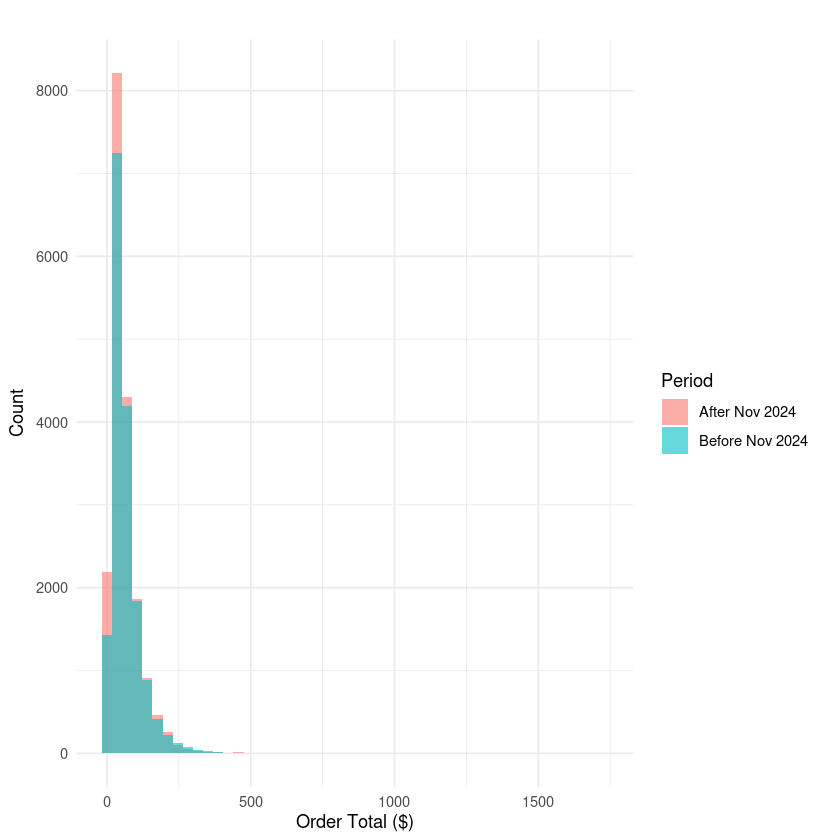

PERIOD,n_orders,mean_order,median_order,sd_order
<chr>,<int>,<dbl>,<dbl>,<dbl>
After Nov 2024,18471,62.24413,46.78,57.21848
Before Nov 2024,16537,65.87037,50.93,53.82959


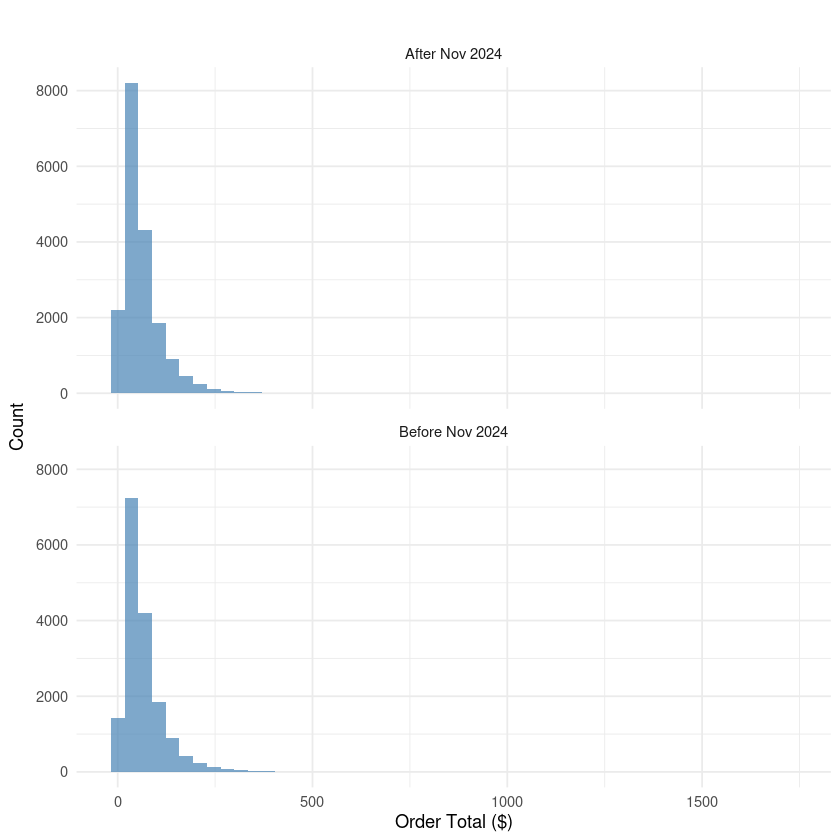

In [18]:
library(duckdb)
library(ggplot2)
library(dplyr)

con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")

query <- "
WITH valid_users AS (
    SELECT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/static_files/standard_nmr_feed_static_table.csv.parquet')
    GROUP BY USER_ID
    HAVING MIN(START_DATE) <= '2024-01-01' AND MAX(END_DATE) >= '2025-06-30'
),
instacart_express_users AS (
    SELECT DISTINCT USER_ID
    FROM read_parquet('/storage/scratch/saichandc/num/people_attribute_files/standard_nmr_feed_people_attribute_table.csv.parquet')
    WHERE TAG_ID = 3001
),
target_users AS (
    SELECT i.USER_ID
    FROM instacart_express_users i
    INNER JOIN valid_users v ON i.USER_ID = v.USER_ID
)
SELECT 
    f.BASKET_ID,
    f.USER_ID,
    TRANSACTION_DATE,
    SUM(ITEM_TOTAL) AS ORDER_TOTAL
FROM read_parquet('/storage/scratch/saichandc/num/*_fact_table.parquet') f
INNER JOIN read_parquet('/storage/scratch/saichandc/num/item_files/SECTOR_ID=isc_grocery/data_0.parquet') g
    ON f.ITEM_ID = g.ITEM_ID
INNER JOIN target_users t
    ON f.USER_ID = t.USER_ID
WHERE TRANSACTION_DATE >= '2024-05-18' AND TRANSACTION_DATE <= '2025-05-18'
    AND f.DELIVERY_PROVIDER = 'instacartcom'
GROUP BY f.BASKET_ID, f.USER_ID, TRANSACTION_DATE
"

df <- dbGetQuery(con, query)
dbDisconnect(con)

# Add before/after period
df <- df %>%
    mutate(PERIOD = ifelse(TRANSACTION_DATE < as.Date("2024-11-01"), "Before Nov 2024", "After Nov 2024"))

# Histogram overlaid
p1 <- ggplot(df, aes(x = ORDER_TOTAL, fill = PERIOD)) +
    geom_histogram(bins = 50, alpha = 0.6, position = "identity") +
    labs(title = "", x = "Order Total ($)", y = "Count", fill = "Period") +
    theme_minimal()

# Histogram faceted
p2 <- ggplot(df, aes(x = ORDER_TOTAL)) +
    geom_histogram(bins = 50, fill = "steelblue", alpha = 0.7) +
    facet_wrap(~PERIOD, ncol = 1) +
    labs(title = "", x = "Order Total ($)", y = "Count") +
    theme_minimal()

options(bitmapType = 'cairo')
print(p1)
print(p2)

ggsave("/storage/home/saichandc/instacart/histogram_overlay.png", p1, width = 10, height = 6)
ggsave("/storage/home/saichandc/instacart/histogram_facet.png", p2, width = 10, height = 8)

# Summary stats
df %>%
    group_by(PERIOD) %>%
    summarise(
        n_orders = n(),
        mean_order = mean(ORDER_TOTAL),
        median_order = median(ORDER_TOTAL),
        sd_order = sd(ORDER_TOTAL)
    )

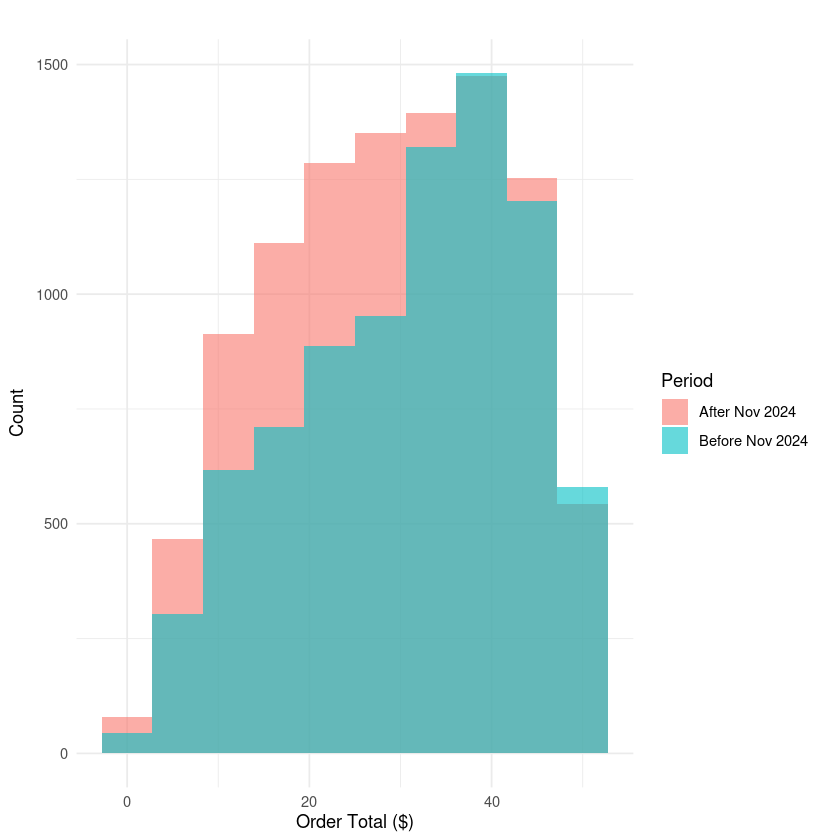

PERIOD,n_orders,mean_order,median_order,sd_order
<chr>,<int>,<dbl>,<dbl>,<dbl>
After Nov 2024,9873,28.74830,29.54,12.39897
Before Nov 2024,8101,30.93927,33.26,12.18621


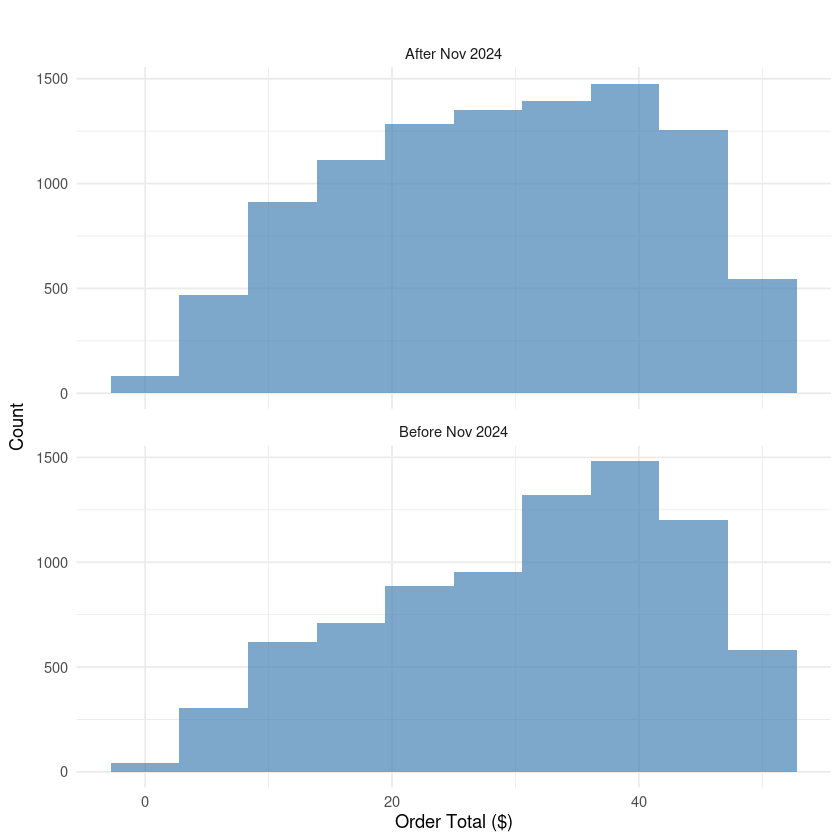

In [22]:
# Filter to orders below $100
df_filtered <- df %>%
    filter(ORDER_TOTAL <= 50)

# Histogram overlaid
p1 <- ggplot(df_filtered, aes(x = ORDER_TOTAL, fill = PERIOD)) +
    geom_histogram(bins = 10, alpha = 0.6, position = "identity") +
    labs(title = "", x = "Order Total ($)", y = "Count", fill = "Period") +
    theme_minimal()

# Histogram faceted
p2 <- ggplot(df_filtered, aes(x = ORDER_TOTAL)) +
    geom_histogram(bins = 10, fill = "steelblue", alpha = 0.7) +
    facet_wrap(~PERIOD, ncol = 1) +
    labs(title = "", x = "Order Total ($)", y = "Count") +
    theme_minimal()

print(p1)
print(p2)

ggsave("/storage/home/saichandc/instacart/histogram_overlay_under100.png", p1, width = 10, height = 6)
ggsave("/storage/home/saichandc/instacart/histogram_facet_under100.png", p2, width = 10, height = 8)

# Summary stats for filtered data
df_filtered %>%
    group_by(PERIOD) %>%
    summarise(
        n_orders = n(),
        mean_order = mean(ORDER_TOTAL),
        median_order = median(ORDER_TOTAL),
        sd_order = sd(ORDER_TOTAL)
    )

PERIOD,pct_under_10,pct_10_to_15,pct_15_to_35,pct_35_to_40,pct_over_40,mean_order,median_order
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
After Nov 2024,7.495189,9.764003,46.65249,13.77494,22.31338,28.74830,29.54
Before Nov 2024,5.715344,7.887915,41.50105,17.91137,26.98432,30.93927,33.26


PERIOD,pct_33_to_37,pct_10_to_14
<chr>,<dbl>,<dbl>
After Nov 2024,10.53378,7.799048
Before Nov 2024,13.73904,6.505370


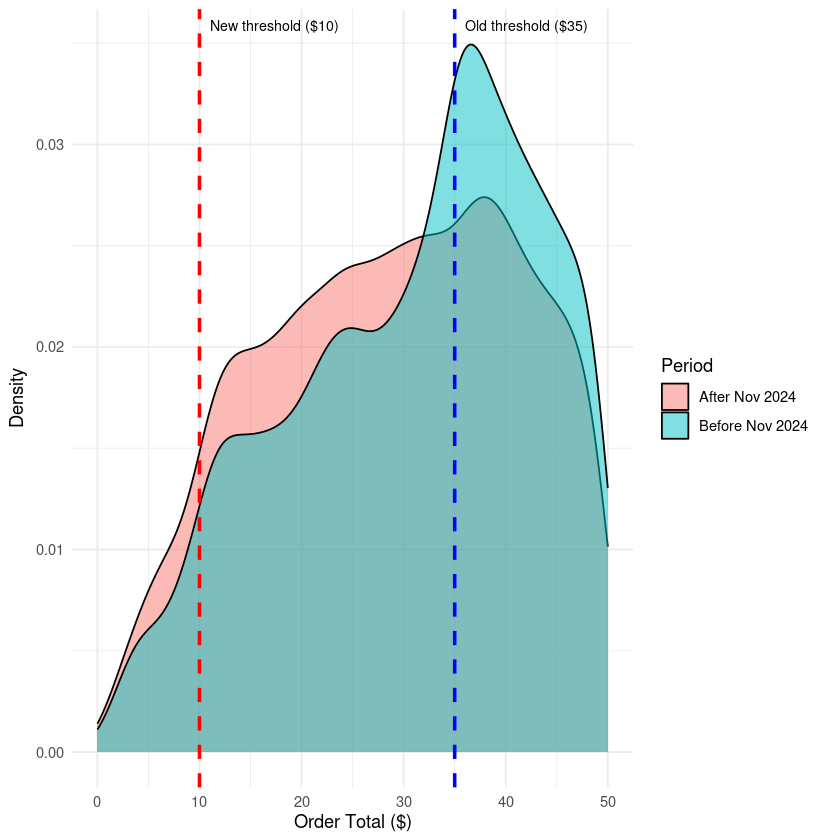

In [23]:
# Density plot with threshold lines
p3 <- ggplot(df_filtered, aes(x = ORDER_TOTAL, fill = PERIOD)) +
    geom_density(alpha = 0.5) +
    geom_vline(xintercept = 10, linetype = "dashed", color = "red", linewidth = 1) +
    geom_vline(xintercept = 35, linetype = "dashed", color = "blue", linewidth = 1) +
    annotate("text", x = 11, y = Inf, label = "New threshold ($10)", vjust = 2, hjust = 0, size = 3) +
    annotate("text", x = 36, y = Inf, label = "Old threshold ($35)", vjust = 2, hjust = 0, size = 3) +
    labs(x = "Order Total ($)", y = "Density", fill = "Period") +
    theme_minimal()

print(p3)

# Proportion of orders in key ranges
df_filtered %>%
    group_by(PERIOD) %>%
    summarise(
        pct_under_10 = mean(ORDER_TOTAL < 10) * 100,
        pct_10_to_15 = mean(ORDER_TOTAL >= 10 & ORDER_TOTAL < 15) * 100,
        pct_15_to_35 = mean(ORDER_TOTAL >= 15 & ORDER_TOTAL < 35) * 100,
        pct_35_to_40 = mean(ORDER_TOTAL >= 35 & ORDER_TOTAL < 40) * 100,
        pct_over_40 = mean(ORDER_TOTAL >= 40) * 100,
        mean_order = mean(ORDER_TOTAL),
        median_order = median(ORDER_TOTAL)
    )

# Bunching analysis - compare density just above vs below thresholds
df_filtered %>%
    group_by(PERIOD) %>%
    summarise(
        # Old threshold bunching (should be higher before Nov)
        pct_33_to_37 = mean(ORDER_TOTAL >= 33 & ORDER_TOTAL <= 37) * 100,
        # New threshold bunching (should be higher after Nov)
        pct_10_to_14 = mean(ORDER_TOTAL >= 10 & ORDER_TOTAL <= 14) * 100
    )